Настройка окружения для работы с библиотекой SoftRas

In [1]:
!wget -O ./miniconda.sh https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh && bash ./miniconda.sh -bfp /usr/local
!conda install -y pytorch==1.1.0 torchvision==0.3.0 cudatoolkit=10.0 -c pytorch
!git clone https://github.com/ShichenLiu/SoftRas.git
!cd SoftRas && conda run -n base python setup.py install
!conda install -y ipykernel

--2021-01-18 23:08:39--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88867207 (85M) [application/x-sh]
Saving to: ‘./miniconda.sh’

./miniconda.sh      100%[===================>]  84.75M   294MB/s    in 0.3s    

2021-01-18 23:08:40 (294 MB/s) - ‘./miniconda.sh’ saved [88867207/88867207]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - ca-certificates==2020.1.1=0
    - certifi==2020.4.5.1=py37_0
    - cffi==1.14.0=py37he30daa8_1
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.1=py37h7b6447c_0
    - conda==4.8.3=py37_0
    - cryptography==2.9.2=py37h1ba5d50_0


Для того чтобы работать с данной библиотекой в Colab, нужно записать команды которые вы хотите выполнить в .py файл, а после

In [2]:
%%writefile test_render.py
import soft_renderer as sr

Writing test_render.py


In [3]:
!conda run -n base python test_render.py

Выполним тестовый пример рендеринга из библиотеки SoftRas. Результаты будут сохранены в дирректории `./SoftRas/data/results`.

In [4]:
!cd SoftRas/examples/ && conda run -n base python demo_render.py

Drawing blurring: 100%|██████████| 10/10 [00:00<00:00, 47.56it/s]



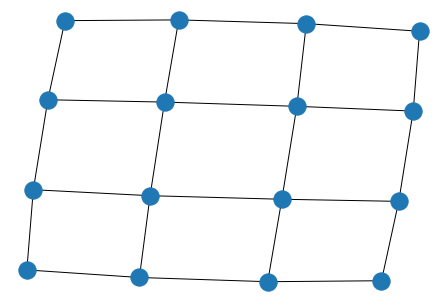

In [5]:
import networkx as nx

G = nx.grid_graph([4, 4])
nx.draw(G)

In [6]:
import numpy as np
from scipy.spatial.distance import cdist
img_size = 28  # MNIST image width and height
col, row = np.meshgrid(np.arange(img_size), np.arange(img_size))
coord = np.stack((col, row), axis=2).reshape(-1, 2) / img_size
dist = cdist(coord, coord)  # рис. 6 (левое изображение)
sigma = 0.2 * np.pi  # width of a Gaussian
A = np.exp(-dist ** 2 / sigma ** 2) # рис.6 (изображение в центре)

In [7]:
import torch
import torch.nn as nn

C = 2  # Input feature dimensionality
F = 8  # Output feature dimensionality
W = nn.Linear(in_features=C, out_features=F)  # Trainable weights

# Fully connected layer
X = torch.randn(1, C)  # Input features
Z = W(X)  # Output features : torch.Size([1, 8])

#Graph Neural Network layer
N = 6  # Number of nodes in a graph
X = torch.randn(N, C)  # Input feature
A = torch.rand(N, N)  # Adjacency matrix (edges of a graph)
Z = W(torch.mm(A, X))  # Output features: torch.Size([6, 8])

In [8]:
import torch.nn as nn           # using PyTorch
nn.Sequential(nn.Linear(4, 64), # map coordinates to a hidden layer
             nn.ReLU(),         # nonlinearity
             nn.Linear(64, 1),  # map hidden representation to edge
             nn.Tanh())         # squash edge values to [-1, 1]

Sequential(
  (0): Linear(in_features=4, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=1, bias=True)
  (3): Tanh()
)

In [9]:
import imageio  # to save GIFs
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cdist
import cv2  # optional (for resizing the filter to look better)

img_size = 28
# Create/load some adjacency matrix A (for example, based on coordinates)
col, row = np.meshgrid(np.arange(img_size), np.arange(img_size))
coord = np.stack((col, row), axis=2).reshape(-1, 2) / img_size
dist = cdist(coord, coord)  # distances between all pairs of pixels
sigma = 0.2 * np.pi  # width of a Gaussian (can be a hyperparameter when training a model)

A = np.exp(- dist / sigma ** 2)  # adjacency matrix of spatial similarity
# above, dist should have been squared to make it a Gaussian (forgot to do that)

scale = 4
img_list = []
cmap = mpl.cm.get_cmap('viridis')
for i in np.arange(0, img_size, 4):  # for every row with step 4
    for j in np.arange(0, img_size, 4):  # for every col with step 4
        k = i*img_size + j
        img = A[k, :].reshape(img_size, img_size)
        img = (img - img.min()) / (img.max() - img.min())
        img = cmap(img)
        img[i, j] = np.array([1., 0, 0, 0])  # add the red dot
        img = cv2.resize(img, (img_size*scale, img_size*scale))
        img_list.append((img * 255).astype(np.uint8))
imageio.mimsave('filter.gif', img_list, format='GIF', duration=0.2)